In [2]:
from cluster_model import get_dataset, get_transformer, DATASET_NAME, MODEL_NAME, SEED, N_DATASIZE, get_block_out_label, N_BLOCKS
import cluster_model

ds = get_dataset(DATASET_NAME)
model, _ = get_transformer(MODEL_NAME)
shuffled = ds.shuffle(seed=SEED)['train'][:N_DATASIZE]['text']

ds = shuffled
labs = [get_block_out_label(i) for i in range(N_BLOCKS)]

/home/lev/code/research/ai/lattice_cluster_paths/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
Moving model to device:  cuda


In [3]:
import importlib
importlib.reload(cluster_model)

# TODO: auto sim cutoff needed
decomp = cluster_model.Decomposer(model, ds, labs)
decomp.load()

Creating decomposer with parameter hash bc59bc4fbdc5fbf0582034fc1f46b24d5a7e80f2
Created dataset
Loading dataset from cache
Got embeddings
Loading cluster scores from cache


In [4]:
decomp.lattice_scores[0].shape

(512, 512)

In [5]:
from typing import List
import utils
importlib.reload(utils)
modified_lattice = decomp.lattice_scores.copy()

# TODO: have function which does something like fixing from the a specific neuron?
# Ie have the sub-lattice with only **related** neurons

def cutoff_lattice(lattice: List[List[List[float]]], related_cutoff = 1):
    print(lattice[0].sum())
    r = [(layer > related_cutoff) * layer for layer in lattice]
    print(r[0].sum())
    return r

def create_sublattice(lattice, layer: int, idx_in_layer: int, related_cutoff = 10):
	with_cutoff = cutoff_lattice(lattice, related_cutoff)

LAST_FEAT = 20
modified_lattice = cutoff_lattice(decomp.lattice_scores, related_cutoff=15)

# utils.top_k_dag_paths_dynamic(modified_lattice, k=10_000)

383.25132816699073
0.0


## Isolate Specific Neurons

In [6]:
import numpy as np

def get_weighting_for_layer(layer: int, n_layers: int, weight_decay=0.95, prior_layers_decay=None):
    if prior_layers_decay is None:
        prior_layers_decay = weight_decay
    r = np.ones(n_layers)
    r[layer] = 1
    G = weight_decay
    for i in range(layer):
        r[i] = prior_layers_decay ** (layer - i)
    for i in range(layer + 1, n_layers):
        # Decrease by Gx per layer
        r[i] = G ** (i - layer)
    return r
    

In [7]:
importlib.reload(utils)
# TODO: restrict lattice, change picture instead of starting elsewhere...
# ~~Use source~~ node
# TODO: ~~SOMEHOW LAYER 2 is where stuff happens~~
cutoff = 0.0
scores_cutoff = [m * (m > cutoff) for m in decomp.lattice_scores]
# paths = utils.top_k_dag_paths(decomp.lattice_scores, layer=0, neuron=25, k=5, exclude_set={2: [239], 3: [368], 5: [236]})
paths = utils.top_k_dag_paths(scores_cutoff, layer=2, neuron=64, k=5)#, exclude_set={2: [239], 3: [368], 5: [236]})
paths

([64, 64, 64, 64, 64, 64], 4.154221508348582)
([64, 64, 64, 263, 263, 263], 3.9078915083485817)
([64, 64, 64, 400, 400, 400], 3.8644415083485817)
([64, 64, 64, 478, 478, 478], 3.8320015083485814)
([56, 56, 64, 64, 64, 64], 3.829681508348582)


[([64, 64, 64, 64, 64, 64], 4.154221508348582),
 ([64, 64, 64, 263, 263, 263], 3.9078915083485817),
 ([64, 64, 64, 400, 400, 400], 3.8644415083485817),
 ([64, 64, 64, 478, 478, 478], 3.8320015083485814),
 ([56, 56, 64, 64, 64, 64], 3.829681508348582)]

In [12]:
def get_feature_paths(lattice, layer: int, neuron: int, k_search=20, n_max_features=5):
    searched_paths = utils.top_k_dag_paths(lattice, layer=layer, neuron=neuron, k=k_search)
    paths = [p[0] for p in searched_paths]

    n_layers = len(lattice)
    def cluster_similar_paths():
        # Get a pairwise "similarity" between the paths
        sims = np.zeros((k_search, k_search))
        for i in range(k_search):
            for j in range(k_search):
                for l in range(n_layers):
                    if paths[i][l] == paths[j][l]:
                        sims[i, j] += 1
        # Now we can employ a greedy-type algorithm
        clusters = []
        path_idx_to_cluster = np.zeros(k_search) - 1
        clustered = np.zeros(k_search) == 1 # A list of whether a path has been clustered

        diff_cutoff = n_layers - 1
        def start_over():
            nonlocal curr_idx, curr_cluster
            curr_idx = 0
            curr_cluster = 0
            clusters.clear()
            path_idx_to_cluster.fill(-1)
            clustered.fill(False)

            clusters.append([curr_idx])
            path_idx_to_cluster[curr_idx] = curr_cluster
            clustered[curr_idx] = True

        start_over()

        while len(clusters) < n_max_features and diff_cutoff > 0:
            for i in range(k_search):
                if not clustered[i] and sims[curr_idx, i] > n_layers - diff_cutoff:
                    clusters[curr_cluster].append(i)
                    clustered[i] = True
                    path_idx_to_cluster[i] = curr_cluster

            found_next = False
            for i in range(k_search):
                if not clustered[i] and sims[curr_idx, i] <= n_layers - diff_cutoff:
                    found_next = True
                    curr_idx = i
                    curr_cluster += 1
                    clusters.append([curr_idx])
                    clustered[curr_idx] = True
                    path_idx_to_cluster[curr_idx] = curr_cluster
                    break
            if not found_next:
                start_over()
                diff_cutoff -= 1
                print("Trying with diff cutoff", diff_cutoff)
        return clusters
        
    paths_distinct = cluster_similar_paths()
    path_reps = [searched_paths[p[0]] for p in paths_distinct]
    return path_reps

get_feature_paths(decomp.lattice_scores, layer=2, neuron=64, k_search=30, n_max_features=10)

([64, 64, 64, 64, 64, 64], 4.154221508348582)
([64, 64, 64, 263, 263, 263], 3.8679715083485817)
([64, 64, 64, 400, 400, 400], 3.8644415083485817)
([64, 64, 64, 478, 478, 478], 3.8320015083485814)
([56, 56, 64, 64, 64, 64], 3.829681508348582)
([64, 64, 64, 410, 410, 410], 3.8226515083485815)
([64, 64, 64, 235, 235, 235], 3.8218515083485816)
([64, 64, 64, 291, 291, 291], 3.8204515083485817)
([276, 276, 64, 64, 64, 64], 3.804601508348582)
([64, 64, 64, 271, 271, 271], 3.797761508348582)
Trying with diff cutoff 3
Trying with diff cutoff 2


[([64, 64, 64, 64, 64, 64], 4.154221508348582),
 ([64, 64, 64, 263, 263, 263], 3.8679715083485817),
 ([64, 64, 64, 400, 400, 400], 3.8644415083485817)]

## Setup for scoring and visualization

In [14]:
import math
import numpy as np
from IPython.core.display import display, HTML
from circuitsvis.utils.render import render

/tmp/ipykernel_15978/672954307.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Try more path like method

In [ ]:
decomp.ds_emb[1].shape

(459325, 512)

In [35]:
"""
score_path = [13, 13, 391, 57, 57, 57]... relates to laws/ licensing
"""

# TODO: SIOMETHING WRONG HERE WITH THE PATHS
import numpy as np
import metric
importlib.reload(cluster_model)
importlib.reload(utils)
importlib.reload(metric)
# score_path = [70, 13, 59, 423, 368, 418]
score_path = [56, 56, 64, 64, 64, 64]
# score_path = [25, 478, 478, 478, 478, 478]
LAYER = 1
# score_path = [0, 0, 69, 51, 195, 99]
# score_path = [69, 1, 107, 289, 97, 508]

"""
Paths which seem to have meaning:

"""

weighting_per_layer = get_weighting_for_layer(LAYER, N_BLOCKS, weight_decay=0.9, prior_layers_decay=0.5)
# weighting_per_layer[0] = 0
# weighting_per_layer[LAYER + 1] = 1
# weighting_per_layer[LAYER + 2] = 1
print(weighting_per_layer)
# to_score = [d[:300] for d in ds][:200]
scores = decomp.score(
    decomp.dataset,
    score_path=score_path,
    weighting_per_layer=weighting_per_layer,
    use_log_scores=True,
    embeds=decomp.ds_emb
)

scores_per_token_set = np.array([max(s) for s in scores])
top_args = np.argsort(scores_per_token_set)[::-1]

# TODO: we have the weights here

tokens = [[model.tokenizer.decode(t) for t in model.tokenizer(d)[
    'input_ids']] for d in decomp.dataset]
tokens_reord = [tokens[i] for i in top_args]
scores_reord = [scores[i] for i in top_args]

[0.5    1.     0.9    0.81   0.729  0.6561]
Scoring on 0 of 459325
Scoring on 12800 of 459325
Scoring on 25600 of 459325
Scoring on 38400 of 459325
Scoring on 51200 of 459325
Scoring on 64000 of 459325
Scoring on 76800 of 459325
Scoring on 89600 of 459325
Scoring on 102400 of 459325
Scoring on 115200 of 459325
Scoring on 128000 of 459325
Scoring on 140800 of 459325
Scoring on 153600 of 459325
Scoring on 166400 of 459325
Scoring on 179200 of 459325
Scoring on 192000 of 459325
Scoring on 204800 of 459325
Scoring on 217600 of 459325
Scoring on 230400 of 459325
Scoring on 243200 of 459325
Scoring on 256000 of 459325
Scoring on 268800 of 459325
Scoring on 281600 of 459325
Scoring on 294400 of 459325
Scoring on 307200 of 459325
Scoring on 320000 of 459325
Scoring on 332800 of 459325
Scoring on 345600 of 459325
Scoring on 358400 of 459325
Scoring on 371200 of 459325
Scoring on 384000 of 459325
Scoring on 396800 of 459325
Scoring on 409600 of 459325
Scoring on 422400 of 459325
Scoring on 43520

In [36]:
# TODO: what up with this max
max_score = max(max(s for s in scores_reord))
max_score

-0.8420298412438229

In [37]:
import math
from IPython.core.display import display, HTML
import math
import numpy as np

act_simp = [[[[math.exp((tok - max_score) * 2)]]
             for tok in s] for s in scores_reord]
# TODO sep fun
html = render(
    "TextNeuronActivations",
    tokens=tokens_reord[:100],
    activations=act_simp[:100],
    firstDimensionName="Layer",
    secondDimensionName="Neuron",
    firstDimensionLabels=None,
    secondDimensionLabels=None
)
display(HTML(str(html)))

/tmp/ipykernel_15978/2915622094.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Look at distributions of scores

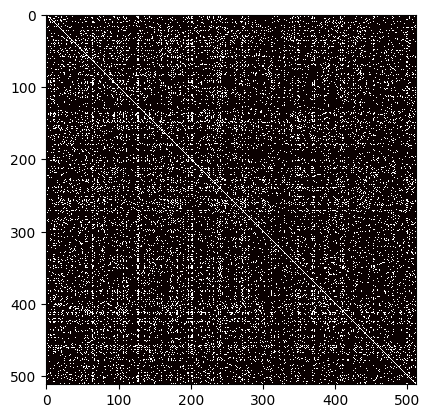

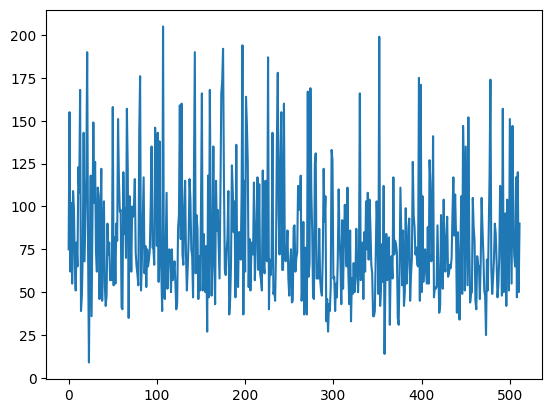

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get distribution of lattice scores

LAYER_START = 4
cutoff = 0.05

# ax = sns.heatmap(decomp.lattice_scores[LAYER_START])
plt.imshow((decomp.lattice_scores[LAYER_START] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

plt.plot((decomp.lattice_scores[3] > cutoff).sum(axis=1))